In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

In [2]:
data_frame = pd.read_csv("./bmi.csv")
data_frame.head()

,Gender,Height,Weight,Index
0,Male,174,96,4
1,Male,189,87,2
2,Female,185,110,4
3,Female,195,104,3
4,Male,149,61,3


In [3]:
data_frame.info() #to determine datatypes and is there any null or missing records? 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Gender  500 non-null    object
 1   Height  500 non-null    int64 
 2   Weight  500 non-null    int64 
 3   Index   500 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 15.8+ KB


In [4]:
data_frame.shape #to determine the shape of the entire dataset

(500, 4)

In [5]:
data_frame.describe() 

,Height,Weight,Index
count,500.000000,500.000000,500.000000
mean,169.944000,106.000000,3.748000
std,16.375261,32.382607,1.355053
min,140.000000,50.000000,0.000000
25%,156.000000,80.000000,3.000000
50%,170.500000,106.000000,4.000000
75%,184.000000,136.000000,5.000000
max,199.000000,160.000000,5.000000


In [6]:
#Method to identify the index of the outliers based on the column name. 
def FindOutlierRecordsBasedOnColumn(dataFrame: pd.DataFrame, columnToCalculateOutlier: str, multiplier: float = 1.5):
    if(not pd.api.types.is_numeric_dtype(dataFrame[columnToCalculateOutlier])):
        raise ValueError("Column must contains numeric values only.")
    quartile1 = dataFrame[columnToCalculateOutlier].quantile(0.25)
    quartile3 = dataFrame[columnToCalculateOutlier].quantile(0.75)
    interQuartileRange = quartile3 - quartile1
    lowerLimit = quartile1 - multiplier * interQuartileRange
    upperLimit = quartile3 +multiplier *interQuartileRange
    return dataFrame[(dataFrame[columnToCalculateOutlier] <= lowerLimit) | (dataFrame[columnToCalculateOutlier] >= upperLimit)].index
    
#method to drop the outlier records.  
def dropOutlierBasedOnColumn(dataFrame: pd.DataFrame, columnToCalculateOutlier):
    return dataFrame.loc[dataFrame.index.difference(FindOutlierRecordsBasedOnColumn(dataFrame, columnToCalculateOutlier))]


In [7]:
print(f"Index of outlier records in height:{FindOutlierRecordsBasedOnColumn(data_frame, "Height")}")
print(f"Index of outlier records in weight:{FindOutlierRecordsBasedOnColumn(data_frame, "Weight")}")

Index of outlier records in height:Index([], dtype='int64')
Index of outlier records in weight:Index([], dtype='int64')


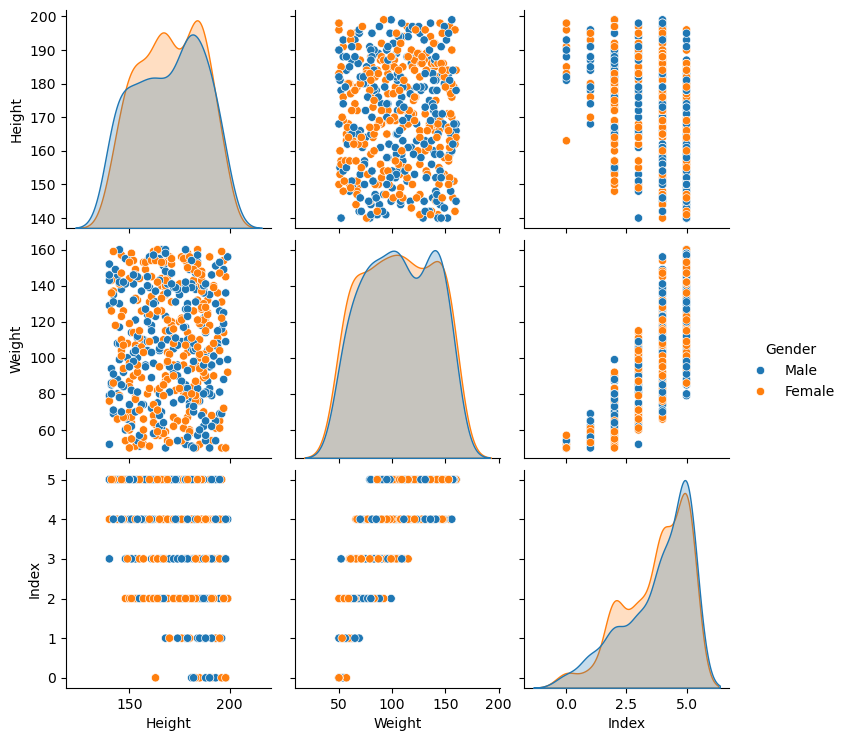

In [8]:
sns.pairplot(data= data_frame, hue= 'Gender') #visualize the relationship and association between features.
plt.show()

In [9]:
gender_value_count= data_frame["Gender"].value_counts() #total data count based on gender
gender_value_count

Gender
Female    255
Male      245
Name: count, dtype: int64

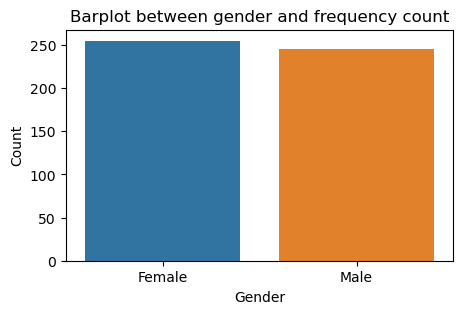

In [10]:
# to visualize the gender frequency in entire dataset
plt.figure(figsize=(5, 3))
sns.barplot(
    x= gender_value_count.index, 
    y= gender_value_count.values, 
    hue= gender_value_count.index)
plt.ylabel("Count")
plt.title("Barplot between gender and frequency count")
plt.show()

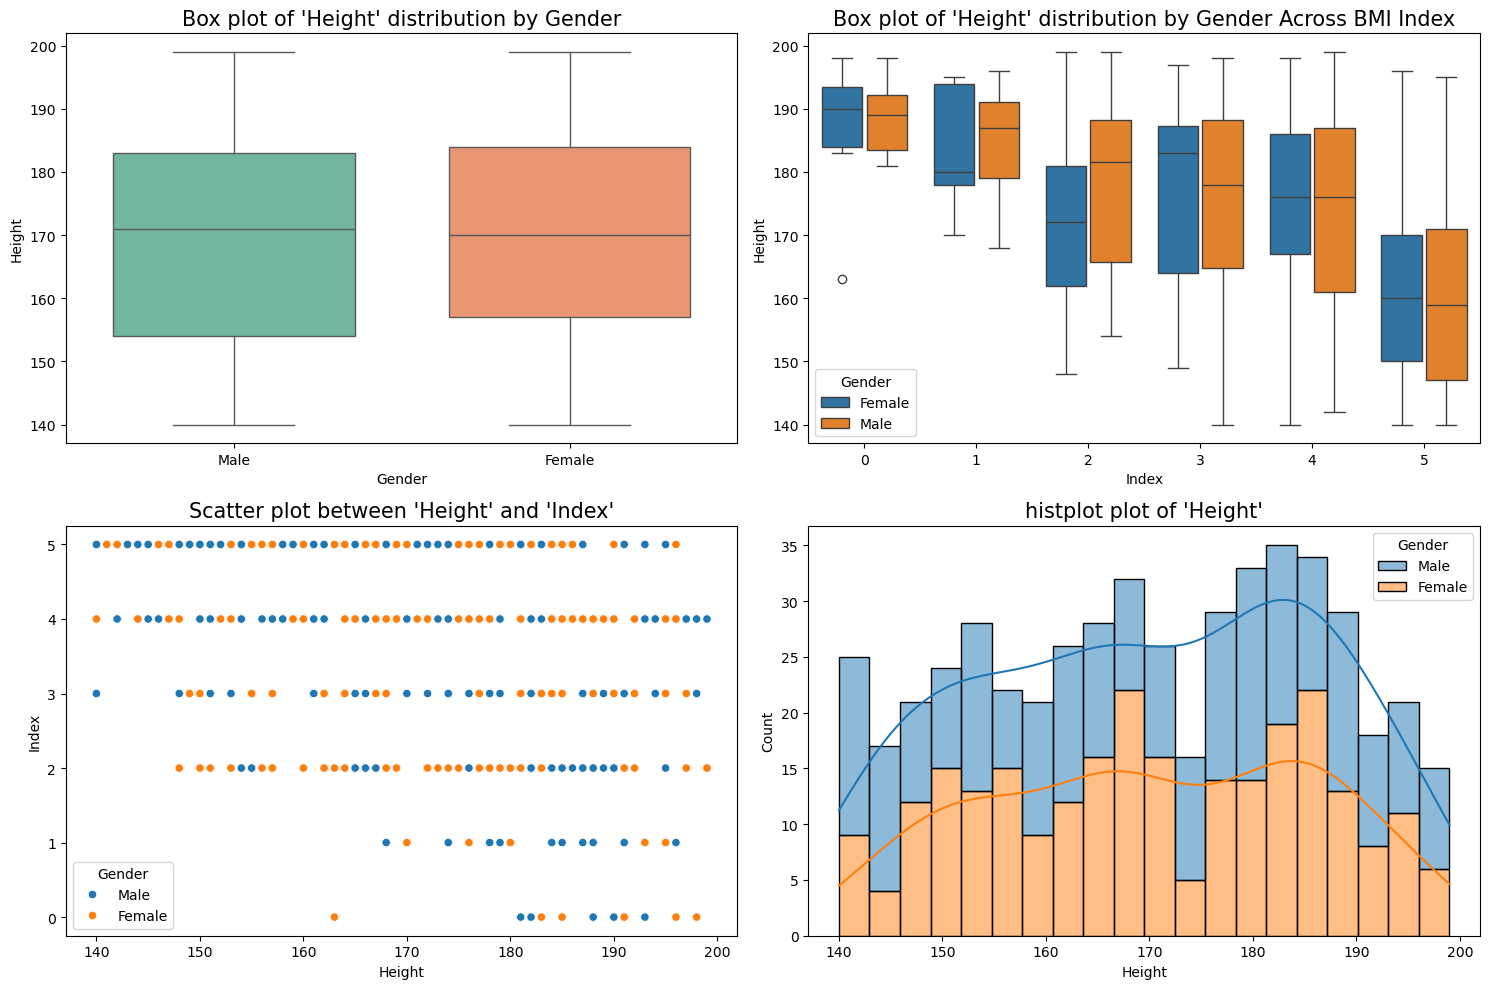

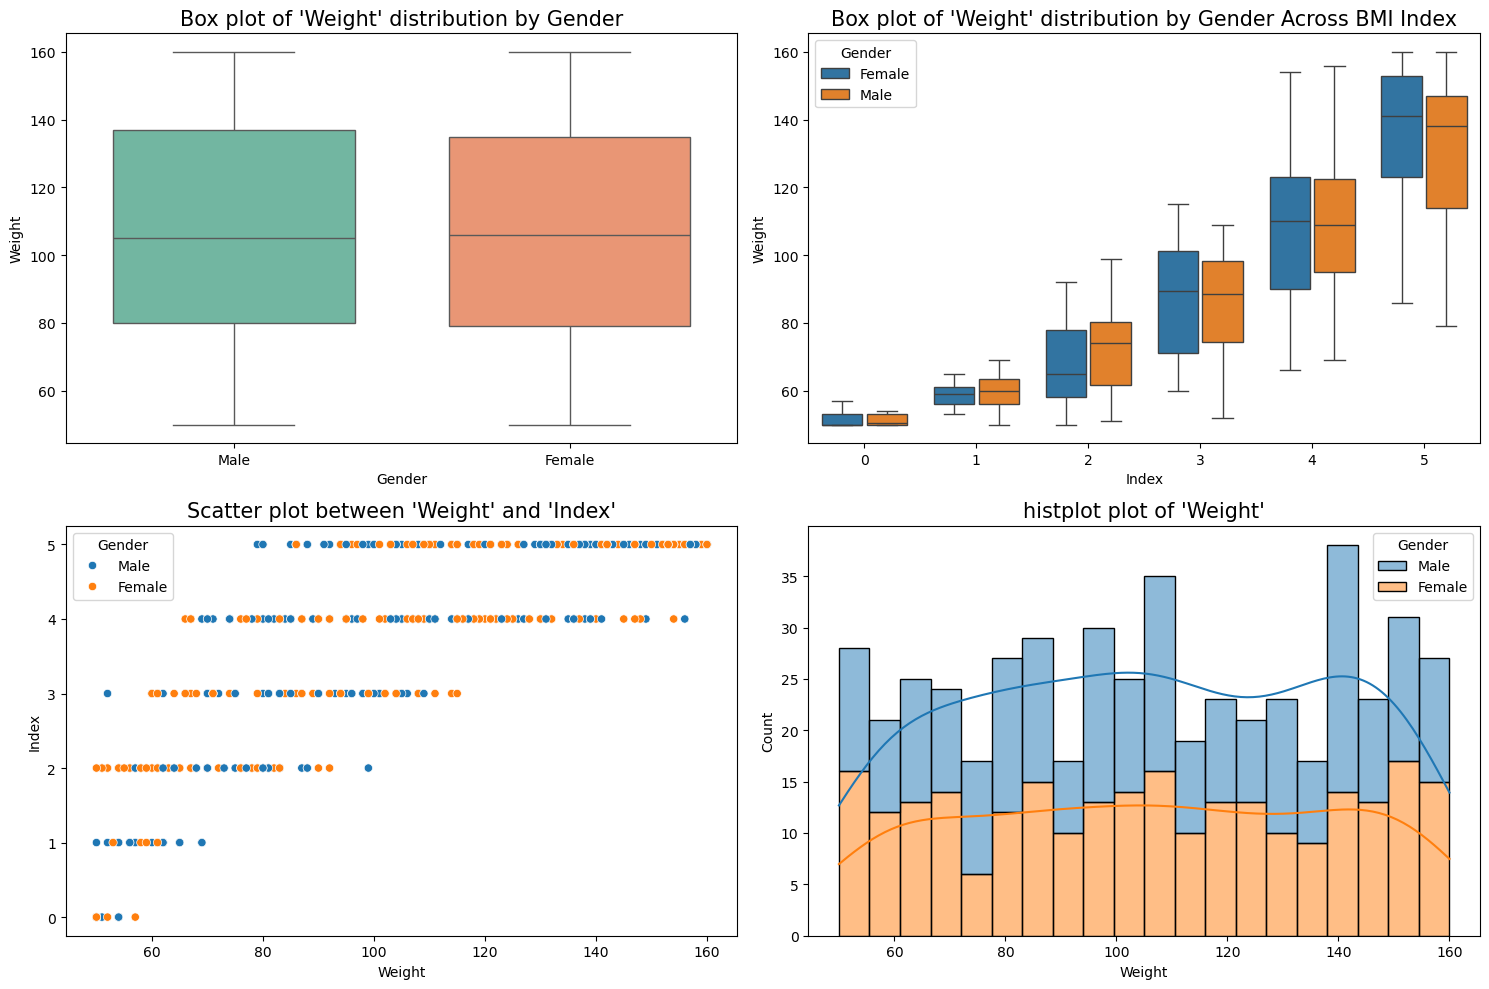

In [11]:
# plotting various graphs for height and weight features. 
column_names = data_frame.columns

for column_name in column_names:
    if(column_name not in ["Gender", "Index"]):
        fig, axs = plt.subplots(2, 2, figsize = (15, 10))

        sns.boxplot(data= data_frame, y= column_name, x= "Gender", ax= axs[0, 0], gap= 0.1, hue= "Gender", palette="Set2")
        axs[0, 0].set_title(f"Box plot of '{column_name}' distribution by Gender", fontsize = 15)

        sns.boxplot(data= data_frame, y= column_name, x= "Index", hue= "Gender",ax= axs[0, 1], gap= 0.1)
        axs[0, 1].set_title(f"Box plot of '{column_name}' distribution by Gender Across BMI Index", fontsize = 15)

        sns.scatterplot(data= data_frame, x= column_name, y= "Index" , ax = axs[1, 0], hue= "Gender")
        axs[1, 0].set_title(f"Scatter plot between '{column_name}' and 'Index'", fontsize = 15)

        sns.histplot(data= data_frame, x= column_name, kde=True,bins = 20, ax = axs[1, 1], hue= "Gender", multiple="stack")
        axs[1, 1].set_title(f"histplot plot of '{column_name}'", fontsize = 15)

        plt.tight_layout()
        plt.show()

In [12]:
#Correlation matrix to identify the association between features
correlation_matrix = data_frame.corr(method= "pearson", numeric_only= True)
correlation_matrix

,Height,Weight,Index
Height,1.000000,0.000446,-0.422223
Weight,0.000446,1.000000,0.804569
Index,-0.422223,0.804569,1.000000


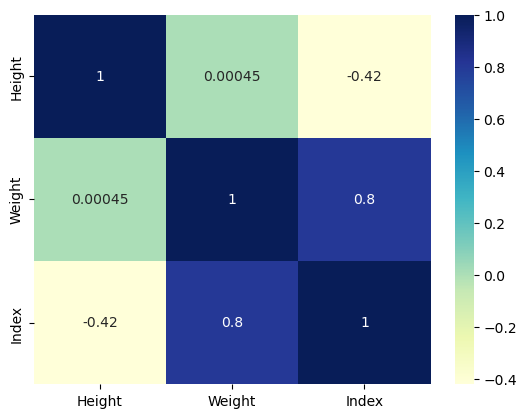

In [13]:
sns.heatmap(data= correlation_matrix, annot= True, cmap= "YlGnBu")
plt.show()

In [14]:
#BMI indexes and their frequency to determine whether data is imbalanced or not. 

bmi_index_count = data_frame["Index"].value_counts() 
bmi_index_count

Index
5    198
4    130
2     69
3     68
1     22
0     13
Name: count, dtype: int64

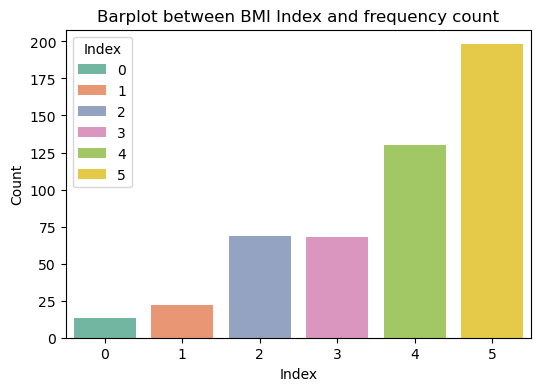

In [15]:
# Visualization of BMI Index frequency

plt.figure(figsize= (6, 4))
sns.barplot(x= bmi_index_count.index, y= bmi_index_count.values, hue= bmi_index_count.index,
    palette= "Set2")
plt.ylabel("Count")
plt.title("Barplot between BMI Index and frequency count")
plt.show()

In [16]:
from sklearn.preprocessing import OneHotEncoder

#Data encoding of the categorical feature "Gender"

encoder = OneHotEncoder(sparse_output= False, drop= "first")

encoded_gender = encoder.fit_transform(data_frame[["Gender"]]).astype(int)
df_encoded_gender = pd.DataFrame(data= encoded_gender, columns= encoder.get_feature_names_out())
df_encoded = pd.concat([data_frame.drop(columns= encoder.feature_names_in_), df_encoded_gender], axis= 1)
df_encoded.head()


,Height,Weight,Index,Gender_Male
0,174,96,4,1
1,189,87,2,1
2,185,110,4,0
3,195,104,3,0
4,149,61,3,1


In [17]:
# Splitting of dataset into train and test set before sampling the records to balance the imbalanced records. 

X_train, X_test, y_train, y_test = train_test_split(
    df_encoded.drop(columns= ["Index"]), 
    df_encoded[["Index"]], 
    random_state= 42, 
    test_size= 0.2,
    stratify= df_encoded[["Gender_Male"]]
    )

In [18]:
random_oversampler = RandomOverSampler(random_state=42)
X_random_resampled, y_random_resampled = random_oversampler.fit_resample(X_train, y_train)

In [19]:
X_random_resampled["Gender_Male"].value_counts() #Identifying Gender classes balanced or not

Gender_Male
0    488
1    478
Name: count, dtype: int64

In [20]:
y_random_resampled["Index"].value_counts() #Identifying target classes balanced or not

Index
4    161
3    161
5    161
0    161
2    161
1    161
Name: count, dtype: int64

In [21]:
#SMOTE oversampling

smote_oversampler = SMOTE(random_state= 42)
X_smote_resampled, y_smote_resampled = smote_oversampler.fit_resample(X_train, y_train)

In [22]:
X_smote_resampled["Gender_Male"].value_counts()

Gender_Male
0    566
1    400
Name: count, dtype: int64

Index
4    161
3    161
5    161
0    161
2    161
1    161
Name: count, dtype: int64


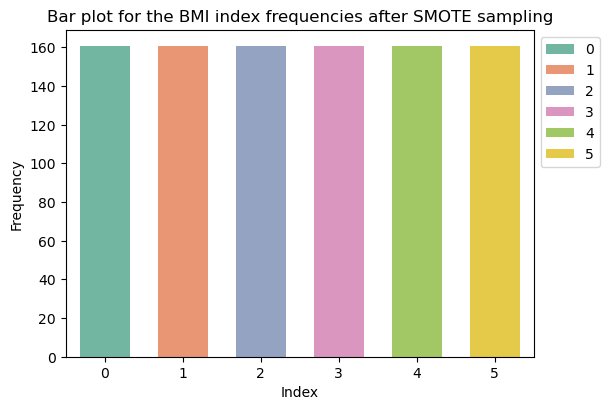

In [23]:
y_sampled_count = y_smote_resampled["Index"].value_counts()
print(y_sampled_count)

# Visualization of smote resampled target variables

plt.figure(figsize=(6, 4))
sns.barplot(x= y_sampled_count.index, y= y_sampled_count.values, hue= y_sampled_count.index,
    palette= "Set2", gap= 0.2)
plt.legend(loc = "best",  bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.title("Bar plot for the BMI index frequencies after SMOTE sampling")
plt.ylabel("Frequency")
plt.show()

SMOTE resampling requires numeric values for all columns before resampling. So, We had to go with OneHotEncoding for column named "Gender". After resampling, It generates records with both Gender_Male and Gender_Female having same values. As we know one record cannot have both fields set to 0 or 1. 

In [24]:
# Random undersampling
random_undersampler = RandomUnderSampler(random_state= 42)
X_random_undersampled, y_random_undersampled = random_undersampler.fit_resample(X_train, y_train)

In [25]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#Normalization and standardization implementation but we choosed standardization records to utilize. 

min_max_scaler = MinMaxScaler()

X_smote_resampled_normalized = min_max_scaler.fit_transform(X_smote_resampled)

standard_scaler = StandardScaler()
X_smote_resampled_standardized = standard_scaler.fit_transform(X_smote_resampled)
# X_smote_resampled_standardized.std()
X_test_standardized = standard_scaler.transform(X_test)


In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [27]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_smote_resampled_standardized, y_smote_resampled.values.ravel())

LogisticRegression()

In [28]:
#logistic regression performance matrics analysis on entire dataset

y_pred_logistic_regression = logistic_regression.predict(X_test_standardized)

accuracy_lr = accuracy_score(y_true= y_test, y_pred= y_pred_logistic_regression)
precision_lr = precision_score(y_true= y_test, y_pred= y_pred_logistic_regression, average= None)
recall_lr = recall_score(y_true= y_test, y_pred= y_pred_logistic_regression, average= None)
f1_lr = f1_score(y_true= y_test, y_pred= y_pred_logistic_regression, average= None)

print(f"Logistic Regression Accuracy: {accuracy_lr}\n")
print(f"Logistic Regression Precision: {precision_lr}\n")
print(f"Logistic Regression Recall: {recall_lr}\n")
print(f"Logistic Regression F1 Score: {f1_lr}\n")


Logistic Regression Accuracy: 0.82

Logistic Regression Precision: [0.6        0.5        0.78947368 0.64705882 0.84210526 0.97222222]

Logistic Regression Recall: [1.         0.4        0.83333333 0.73333333 0.72727273 0.94594595]

Logistic Regression F1 Score: [0.75       0.44444444 0.81081081 0.6875     0.7804878  0.95890411]



In [29]:
# Print a confusion matrix for logistic regression on entire dataset
confusion_matrix_lr= (confusion_matrix(y_test, y_pred_logistic_regression))

confusion_matrix_lr_df = pd.DataFrame(confusion_matrix_lr, index= ["Actual 0", "Actual 1", "Actual 2", "Actual 3", "Actual 4", "Actual 5"], 
                     columns=["Predicted 0", "Predicted 1", "Predicted 2", "Predicted 3", "Predicted 4", "Predicted 5"])
confusion_matrix_lr_df

,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5
Actual 0,3,0,0,0,0,0
Actual 1,2,2,1,0,0,0
Actual 2,0,2,15,1,0,0
Actual 3,0,0,3,11,1,0
Actual 4,0,0,0,5,16,1
Actual 5,0,0,0,0,2,35


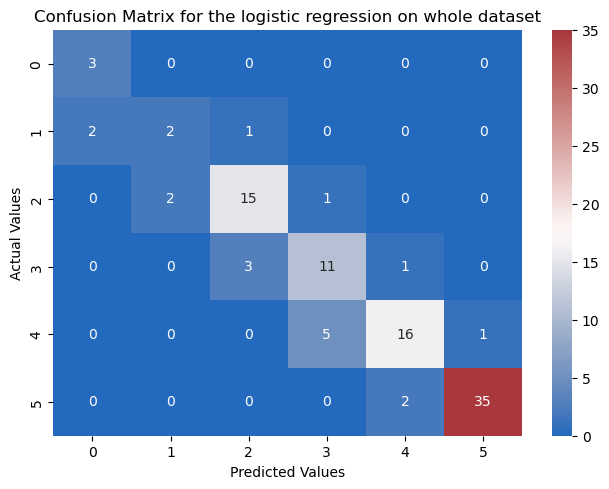

In [30]:
# Confusion matrix in heatmap visualization

sns.heatmap(data= confusion_matrix_lr, annot= True, cmap= "vlag")
plt.title("Confusion Matrix for the logistic regression on whole dataset")
plt.tight_layout()
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [31]:
# Print a classification report for logistic regression model
classification_report_lr = (classification_report(y_test, y_pred_logistic_regression))
print(classification_report_lr)

              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       0.50      0.40      0.44         5
           2       0.79      0.83      0.81        18
           3       0.65      0.73      0.69        15
           4       0.84      0.73      0.78        22
           5       0.97      0.95      0.96        37

    accuracy                           0.82       100
   macro avg       0.73      0.77      0.74       100
weighted avg       0.83      0.82      0.82       100



In [32]:
k_nearest_neighbour = KNeighborsClassifier(n_neighbors= 10)
k_nearest_neighbour.fit(X_smote_resampled_standardized, y_smote_resampled.values.ravel())

KNeighborsClassifier(n_neighbors=10)

In [33]:
y_pred_knn = k_nearest_neighbour.predict(X_test_standardized)
accuracy_knn = accuracy_score(y_true= y_test, y_pred= y_pred_knn)
precision_knn = precision_score(y_true= y_test, y_pred= y_pred_knn, average= None)
recall_knn = recall_score(y_true= y_test, y_pred= y_pred_knn, average= None)
f1_knn = f1_score(y_true= y_test, y_pred= y_pred_knn, average= None)

print(f"K Nearest Neighbour Accuracy: {accuracy_knn}\n")
print(f"K Nearest Neighbour Precision: {precision_knn}\n")
print(f"K Nearest Neighbour Recall: {recall_knn}\n")
print(f"K Nearest Neighbour F1 Score: {f1_knn}\n")

K Nearest Neighbour Accuracy: 0.82

K Nearest Neighbour Precision: [0.75       0.44444444 0.81818182 0.64705882 0.83333333 1.        ]

K Nearest Neighbour Recall: [1.         0.8        0.5        0.73333333 0.90909091 0.94594595]

K Nearest Neighbour F1 Score: [0.85714286 0.57142857 0.62068966 0.6875     0.86956522 0.97222222]



In [34]:
# Print a confusion matrix for KNN model on entire dataset
confusion_matrix_knn= (confusion_matrix(y_test, y_pred_knn))

confusion_matrix_knn_df = pd.DataFrame(confusion_matrix_knn, index= ["Actual 0", "Actual 1", "Actual 2", "Actual 3", "Actual 4", "Actual 5"], 
                     columns=["Predicted 0", "Predicted 1", "Predicted 2", "Predicted 3", "Predicted 4", "Predicted 5"])
confusion_matrix_knn_df

,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5
Actual 0,3,0,0,0,0,0
Actual 1,1,4,0,0,0,0
Actual 2,0,5,9,4,0,0
Actual 3,0,0,2,11,2,0
Actual 4,0,0,0,2,20,0
Actual 5,0,0,0,0,2,35


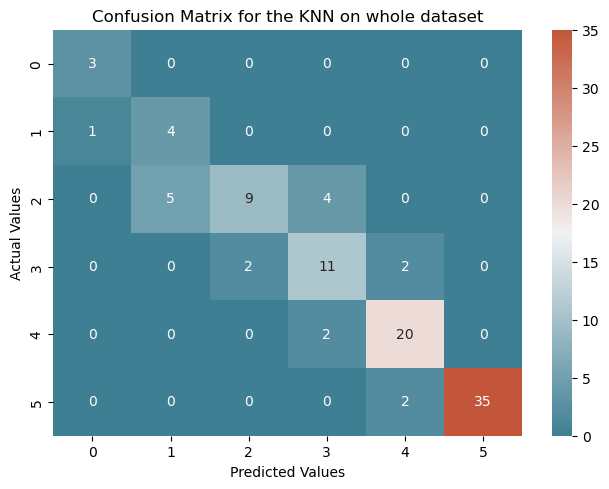

In [35]:
# Heatmap visualization of KNN confusion matrix

sns.heatmap(data= confusion_matrix_knn, annot= True, cmap= sns.diverging_palette(220, 20, as_cmap=True))
plt.title("Confusion Matrix for the KNN on whole dataset")
plt.tight_layout()
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [36]:
classification_report_knn = (classification_report(y_test, y_pred_knn))
print(classification_report_knn)

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       0.44      0.80      0.57         5
           2       0.82      0.50      0.62        18
           3       0.65      0.73      0.69        15
           4       0.83      0.91      0.87        22
           5       1.00      0.95      0.97        37

    accuracy                           0.82       100
   macro avg       0.75      0.81      0.76       100
weighted avg       0.84      0.82      0.82       100



In [37]:
support_vector_machine = svm.SVC(kernel='linear', random_state=42)
support_vector_machine.fit(X_smote_resampled_standardized, y_smote_resampled.values.ravel())


SVC(kernel='linear', random_state=42)

In [38]:
#Support vector machine performance matrices

y_pred_svc = support_vector_machine.predict(X_test_standardized)
accuracy_svc = accuracy_score(y_true= y_test, y_pred= y_pred_svc)
precision_svc = precision_score(y_true= y_test, y_pred= y_pred_svc, average= None)
recall_svc = recall_score(y_true= y_test, y_pred= y_pred_svc, average= None)
f1_svc = f1_score(y_true= y_test, y_pred= y_pred_svc, average= None)

print(f"Support Vector Machine Accuracy: {accuracy_svc}\n")
print(f"Support Vector Machine Precision: {precision_svc}\n")
print(f"Support Vector Machine Recall: {recall_svc}\n")
print(f"Support Vector Machine F1 Score: {f1_svc}\n")

Support Vector Machine Accuracy: 0.9

Support Vector Machine Precision: [1.         0.71428571 0.9375     0.72222222 0.9        1.        ]

Support Vector Machine Recall: [1.         1.         0.83333333 0.86666667 0.81818182 0.97297297]

Support Vector Machine F1 Score: [1.         0.83333333 0.88235294 0.78787879 0.85714286 0.98630137]



In [39]:
# Print a confusion matrix for support vector machine on entire dataset.
confusion_matrix_svm= (confusion_matrix(y_test, y_pred_svc))

confusion_matrix_svm_df = pd.DataFrame(confusion_matrix_svm, index= ["Actual 0", "Actual 1", "Actual 2", "Actual 3", "Actual 4", "Actual 5"], 
                     columns=["Predicted 0", "Predicted 1", "Predicted 2", "Predicted 3", "Predicted 4", "Predicted 5"])
confusion_matrix_svm_df

,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5
Actual 0,3,0,0,0,0,0
Actual 1,0,5,0,0,0,0
Actual 2,0,2,15,1,0,0
Actual 3,0,0,1,13,1,0
Actual 4,0,0,0,4,18,0
Actual 5,0,0,0,0,1,36


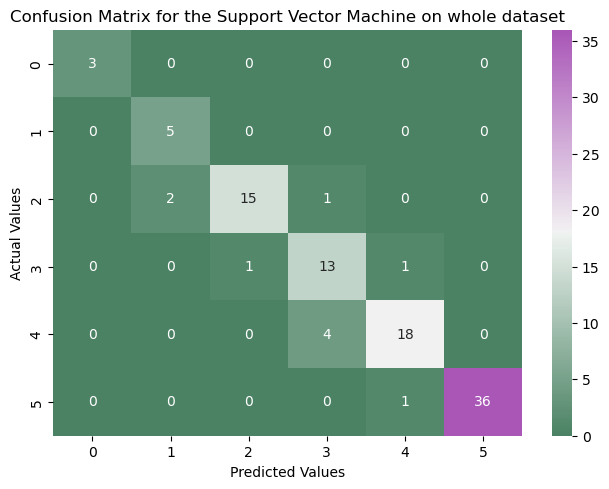

In [40]:
# Heatmap visualization of SVM confusion matrix
sns.heatmap(data= confusion_matrix_svm, annot= True, cmap= sns.diverging_palette(145, 300, s=60, as_cmap=True))
plt.title("Confusion Matrix for the Support Vector Machine on whole dataset")
plt.tight_layout()
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [41]:
classification_report_svc = (classification_report(y_test, y_pred_svc))
print(classification_report_svc)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.71      1.00      0.83         5
           2       0.94      0.83      0.88        18
           3       0.72      0.87      0.79        15
           4       0.90      0.82      0.86        22
           5       1.00      0.97      0.99        37

    accuracy                           0.90       100
   macro avg       0.88      0.92      0.89       100
weighted avg       0.91      0.90      0.90       100



# Gender Specific classification models

In [42]:
#dataframe for male 
df_male = data_frame[data_frame["Gender"] == "Male"].drop(columns= ["Gender"]).reset_index(drop= True)
df_male.head()

,Height,Weight,Index
0,174,96,4
1,189,87,2
2,149,61,3
3,189,104,3
4,147,92,5


In [43]:
df_male.shape

(245, 3)

In [44]:
df_male_value_count= df_male["Index"].value_counts().sort_values()
df_male_value_count

Index
0      6
1     15
2     28
3     32
4     59
5    105
Name: count, dtype: int64

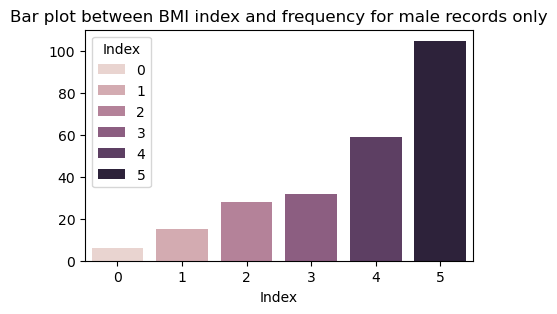

In [45]:
# Bar plot between BMI index and frequency for male records only

plt.figure(figsize=(5, 3))
sns.barplot(x = df_male_value_count.index, y = df_male_value_count.values, hue= df_male_value_count.index)
plt.title("Bar plot between BMI index and frequency for male records only")
plt.show()

In [46]:
# Train test split for male specific model

X_male_train, X_male_test, y_male_train, y_male_test = train_test_split(
    df_male.drop(columns= ["Index"]), 
    df_male[["Index"]], 
    test_size= 0.2,
    stratify= df_male[["Index"]]
    )

print(y_male_train["Index"].value_counts().sort_values())

Index
0     5
1    12
2    22
3    26
4    47
5    84
Name: count, dtype: int64


In [47]:
#SMOTE oversampling
smote_oversampler_male = SMOTE(random_state= 42, k_neighbors= 4)
X_smote_resampled_male, y_smote_resampled_male = smote_oversampler_male.fit_resample(X_male_train, y_male_train)

In [48]:
y_smote_resampled_male.value_counts().sort_index()

Index
0        84
1        84
2        84
3        84
4        84
5        84
Name: count, dtype: int64

In [49]:
standard_scaler_male = StandardScaler()
X_smote_resampled_male_standardized = standard_scaler_male.fit_transform(X_smote_resampled_male)
X_male_test_standardized = standard_scaler_male.transform(X_male_test)

In [50]:
logistic_regression_male = LogisticRegression()
logistic_regression_male.fit(X_smote_resampled_male_standardized, y_smote_resampled_male.values.ravel())

LogisticRegression()

In [51]:
y_pred_male_logistic_regression = logistic_regression_male.predict(X_male_test_standardized)

accuracy_lr_male = accuracy_score(y_true= y_male_test, y_pred= y_pred_male_logistic_regression)
precision_lr_male = precision_score(y_true= y_male_test, y_pred= y_pred_male_logistic_regression, average= None)
recall_lr_male = recall_score(y_true= y_male_test, y_pred= y_pred_male_logistic_regression, average= None)
f1_lr_male = f1_score(y_true= y_male_test, y_pred= y_pred_male_logistic_regression, average= None)

print(f"Male Logistic Regression Accuracy: {accuracy_lr_male}\n")
print(f"Male Logistic Regression Precision: {precision_lr_male}\n")
print(f"Male Logistic Regression Recall: {recall_lr_male}\n")
print(f"Male Logistic Regression F1 Score: {f1_lr_male}\n")

Male Logistic Regression Accuracy: 0.9183673469387755

Male Logistic Regression Precision: [0.5        1.         1.         0.85714286 0.91666667 0.95238095]

Male Logistic Regression Recall: [1.         0.66666667 0.83333333 1.         0.91666667 0.95238095]

Male Logistic Regression F1 Score: [0.66666667 0.8        0.90909091 0.92307692 0.91666667 0.95238095]



In [52]:
# Print a confusion matrix
confusion_matrix_male_lr= (confusion_matrix(y_male_test, y_pred_male_logistic_regression))

confusion_matrix_male_lr_df = pd.DataFrame(confusion_matrix_male_lr, index= ["Actual 0", "Actual 1", "Actual 2", "Actual 3", "Actual 4", "Actual 5"], 
                     columns=["Predicted 0", "Predicted 1", "Predicted 2", "Predicted 3", "Predicted 4", "Predicted 5"])
confusion_matrix_male_lr_df

,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5
Actual 0,1,0,0,0,0,0
Actual 1,1,2,0,0,0,0
Actual 2,0,0,5,1,0,0
Actual 3,0,0,0,6,0,0
Actual 4,0,0,0,0,11,1
Actual 5,0,0,0,0,1,20


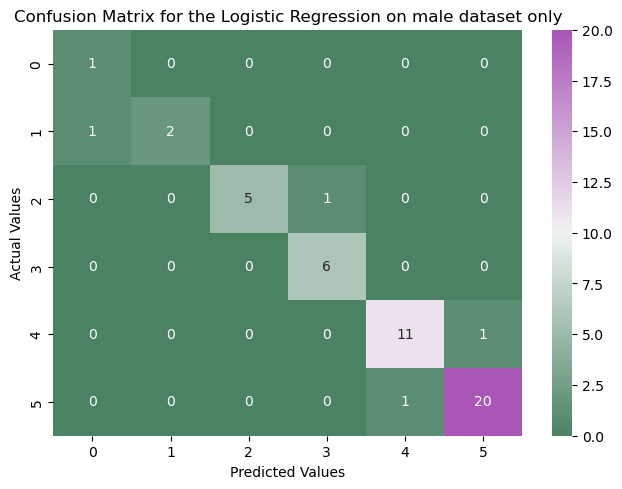

In [53]:
# Heat map for Confusion Matrix for the Logistic Regression on male dataset only
sns.heatmap(data= confusion_matrix_male_lr, annot= True, cmap= sns.diverging_palette(145, 300, s=60, as_cmap=True))
plt.title("Confusion Matrix for the Logistic Regression on male dataset only")
plt.tight_layout()
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [54]:
classification_report_male_lr = (classification_report(y_male_test, y_pred_male_logistic_regression))
print(classification_report_male_lr)

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      0.67      0.80         3
           2       1.00      0.83      0.91         6
           3       0.86      1.00      0.92         6
           4       0.92      0.92      0.92        12
           5       0.95      0.95      0.95        21

    accuracy                           0.92        49
   macro avg       0.87      0.89      0.86        49
weighted avg       0.93      0.92      0.92        49



In [55]:
k_nearest_neighbour_male = KNeighborsClassifier()
k_nearest_neighbour_male.fit(X_smote_resampled_male_standardized, y_smote_resampled_male.values.ravel())

KNeighborsClassifier()

In [56]:
y_pred_male_knn = k_nearest_neighbour_male.predict(X_male_test_standardized)

accuracy_knn_male = accuracy_score(y_true= y_male_test, y_pred= y_pred_male_knn)
precision_knn_male = precision_score(y_true= y_male_test, y_pred= y_pred_male_knn, average= None)
recall_knn_male = recall_score(y_true= y_male_test, y_pred= y_pred_male_knn, average= None)
f1_knn_male = f1_score(y_true= y_male_test, y_pred= y_pred_male_knn, average= None)

print(f"Male Logistic Regression Accuracy: {accuracy_knn_male}\n")
print(f"Male Logistic Regression Precision: {precision_knn_male}\n")
print(f"Male Logistic Regression Recall: {recall_knn_male}\n")
print(f"Male Logistic Regression F1 Score: {f1_knn_male}\n")

Male Logistic Regression Accuracy: 0.8979591836734694

Male Logistic Regression Precision: [0.5        1.         1.         0.85714286 0.84615385 0.95      ]

Male Logistic Regression Recall: [1.         0.66666667 0.83333333 1.         0.91666667 0.9047619 ]

Male Logistic Regression F1 Score: [0.66666667 0.8        0.90909091 0.92307692 0.88       0.92682927]



In [57]:
# Print a confusion matrix
confusion_matrix_male_knn= (confusion_matrix(y_male_test, y_pred_male_knn))

confusion_matrix_male_knn_df = pd.DataFrame(confusion_matrix_male_knn, index= ["Actual 0", "Actual 1", "Actual 2", "Actual 3", "Actual 4", "Actual 5"], 
                     columns=["Predicted 0", "Predicted 1", "Predicted 2", "Predicted 3", "Predicted 4", "Predicted 5"])
confusion_matrix_male_knn_df

,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5
Actual 0,1,0,0,0,0,0
Actual 1,1,2,0,0,0,0
Actual 2,0,0,5,1,0,0
Actual 3,0,0,0,6,0,0
Actual 4,0,0,0,0,11,1
Actual 5,0,0,0,0,2,19


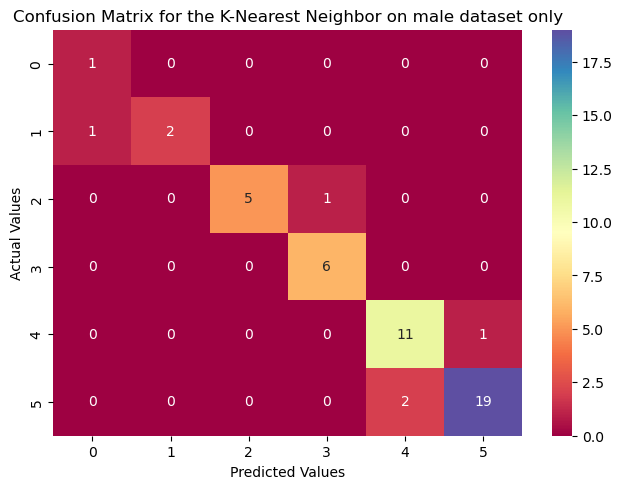

In [58]:
# Heat map for Confusion Matrix for the K-Nearest Neighbor model on male dataset only
sns.heatmap(data= confusion_matrix_male_knn, annot= True, cmap= sns.color_palette("Spectral", as_cmap=True))
plt.title("Confusion Matrix for the K-Nearest Neighbor on male dataset only")
plt.tight_layout()
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [59]:
classification_report_male_knn = (classification_report(y_male_test, y_pred_male_knn))
print(classification_report_male_knn)

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      0.67      0.80         3
           2       1.00      0.83      0.91         6
           3       0.86      1.00      0.92         6
           4       0.85      0.92      0.88        12
           5       0.95      0.90      0.93        21

    accuracy                           0.90        49
   macro avg       0.86      0.89      0.85        49
weighted avg       0.91      0.90      0.90        49



In [60]:
support_vector_machine_male = svm.SVC()
support_vector_machine_male.fit(X_smote_resampled_male_standardized, y_smote_resampled_male.values.ravel())

SVC()

In [61]:
y_pred_male_svm = support_vector_machine_male.predict(X_male_test_standardized)

accuracy_svm_male = accuracy_score(y_true= y_male_test, y_pred= y_pred_male_svm)
precision_svm_male = precision_score(y_true= y_male_test, y_pred= y_pred_male_svm, average= None)
recall_svm_male = recall_score(y_true= y_male_test, y_pred= y_pred_male_svm, average= None)
f1_svm_male = f1_score(y_true= y_male_test, y_pred= y_pred_male_svm, average= None)

print(f"Male Logistic Regression Accuracy: {accuracy_svm_male}\n")
print(f"Male Logistic Regression Precision: {precision_svm_male}\n")
print(f"Male Logistic Regression Recall: {recall_svm_male}\n")
print(f"Male Logistic Regression F1 Score: {f1_svm_male}\n")

Male Logistic Regression Accuracy: 0.8979591836734694

Male Logistic Regression Precision: [0.5        1.         1.         0.85714286 0.84615385 0.95      ]

Male Logistic Regression Recall: [1.         0.66666667 0.83333333 1.         0.91666667 0.9047619 ]

Male Logistic Regression F1 Score: [0.66666667 0.8        0.90909091 0.92307692 0.88       0.92682927]



In [62]:
# Print a confusion matrix
confusion_matrix_male_svm= (confusion_matrix(y_male_test, y_pred_male_svm))

confusion_matrix_male_svm_df = pd.DataFrame(confusion_matrix_male_svm, index= ["Actual 0", "Actual 1", "Actual 2", "Actual 3", "Actual 4", "Actual 5"], 
                     columns=["Predicted 0", "Predicted 1", "Predicted 2", "Predicted 3", "Predicted 4", "Predicted 5"])
confusion_matrix_male_svm_df

,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5
Actual 0,1,0,0,0,0,0
Actual 1,1,2,0,0,0,0
Actual 2,0,0,5,1,0,0
Actual 3,0,0,0,6,0,0
Actual 4,0,0,0,0,11,1
Actual 5,0,0,0,0,2,19


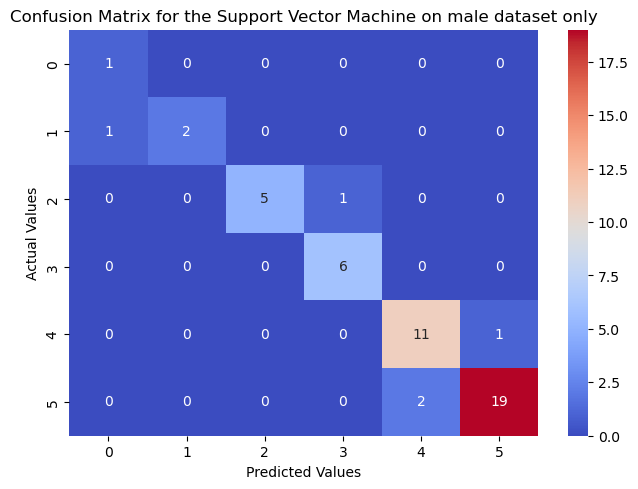

In [63]:
# Heat map for Confusion Matrix for the Support Vector Machine on male dataset only
sns.heatmap(data= confusion_matrix_male_svm, annot= True, cmap= sns.color_palette("coolwarm", as_cmap=True))
plt.title("Confusion Matrix for the Support Vector Machine on male dataset only")
plt.tight_layout()
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [64]:
#Classification report for male SVM classification model
classification_report_male_svm = (classification_report(y_male_test, y_pred_male_svm))
print(classification_report_male_svm)

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      0.67      0.80         3
           2       1.00      0.83      0.91         6
           3       0.86      1.00      0.92         6
           4       0.85      0.92      0.88        12
           5       0.95      0.90      0.93        21

    accuracy                           0.90        49
   macro avg       0.86      0.89      0.85        49
weighted avg       0.91      0.90      0.90        49



# Classification Models for Female

In [65]:
#dataframe for male 
df_female = data_frame[data_frame["Gender"] == "Female"].drop(columns= ["Gender"]).reset_index(drop= True)
df_female.head()

,Height,Weight,Index
0,185,110,4
1,195,104,3
2,169,103,4
3,159,80,4
4,192,101,3


In [66]:
df_female.shape

(255, 3)

In [67]:
df_female_value_count= df_female["Index"].value_counts().sort_index()
df_female_value_count

Index
0     7
1     7
2    41
3    36
4    71
5    93
Name: count, dtype: int64

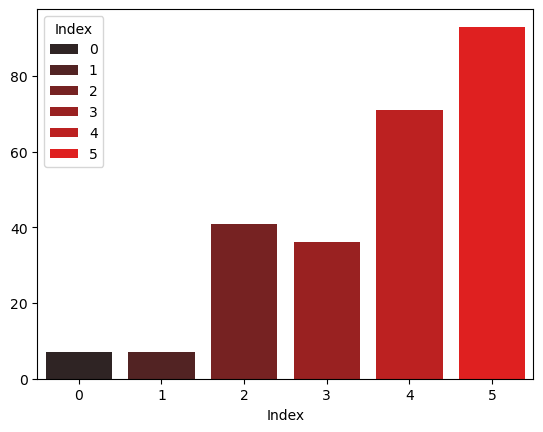

In [68]:
sns.barplot(x = df_female_value_count.index, y = df_female_value_count.values, hue= df_female_value_count.index, palette='dark:red')
plt.show()

In [69]:
X_female_train, X_female_test, y_female_train, y_female_test = train_test_split(
    df_female.drop(columns= ["Index"]), 
    df_female[["Index"]], 
    test_size= 0.2,
    stratify= df_female[["Index"]]
    )

print(y_female_train["Index"].value_counts().sort_values())

Index
0     5
1     6
3    29
2    33
4    57
5    74
Name: count, dtype: int64


In [70]:
#SMOTE oversampling
smote_oversampler_female = SMOTE(random_state= 42, k_neighbors= 4)
X_smote_resampled_female, y_smote_resampled_female = smote_oversampler_female.fit_resample(X_female_train, y_female_train)

In [71]:
y_smote_resampled_female.value_counts().sort_index()

Index
0        74
1        74
2        74
3        74
4        74
5        74
Name: count, dtype: int64

In [72]:
standard_scaler_female = StandardScaler()
X_smote_resampled_female_standardized = standard_scaler_female.fit_transform(X_smote_resampled_female)
# X_smote_resampled_standardized.std()
X_female_test_standardized = standard_scaler_female.transform(X_female_test)

In [73]:
logistic_regression_female = LogisticRegression()
logistic_regression_female.fit(X_smote_resampled_female_standardized, y_smote_resampled_female.values.ravel())

LogisticRegression()

In [74]:
y_pred_female_logistic_regression = logistic_regression_female.predict(X_female_test_standardized)

accuracy_lr_female = accuracy_score(y_true= y_female_test, y_pred= y_pred_female_logistic_regression)
precision_lr_female = precision_score(y_true= y_female_test, y_pred= y_pred_female_logistic_regression, average= None)
recall_lr_female = recall_score(y_true= y_female_test, y_pred= y_pred_female_logistic_regression, average= None)
f1_lr_female = f1_score(y_true= y_female_test, y_pred= y_pred_female_logistic_regression, average= None)

print(f"Female Logistic Regression Accuracy: {accuracy_lr_female}\n")
print(f"Female Logistic Regression Precision: {precision_lr_female}\n")
print(f"Female Logistic Regression Recall: {recall_lr_female}\n")
print(f"Female Logistic Regression F1 Score: {f1_lr_female}\n")

Female Logistic Regression Accuracy: 0.7843137254901961

Female Logistic Regression Precision: [0.66666667 0.5        0.75       0.6        0.8        0.94117647]

Female Logistic Regression Recall: [1.         1.         0.375      0.85714286 0.85714286 0.84210526]

Female Logistic Regression F1 Score: [0.8        0.66666667 0.5        0.70588235 0.82758621 0.88888889]



In [75]:
# Print a confusion matrix
confusion_matrix_female_lr= (confusion_matrix(y_female_test, y_pred_female_logistic_regression))

confusion_matrix_female_lr_df = pd.DataFrame(confusion_matrix_female_lr, index= ["Actual 0", "Actual 1", "Actual 2", "Actual 3", "Actual 4", "Actual 5"], 
                     columns=["Predicted 0", "Predicted 1", "Predicted 2", "Predicted 3", "Predicted 4", "Predicted 5"])
confusion_matrix_female_lr_df

,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5
Actual 0,2,0,0,0,0,0
Actual 1,0,1,0,0,0,0
Actual 2,1,1,3,3,0,0
Actual 3,0,0,1,6,0,0
Actual 4,0,0,0,1,12,1
Actual 5,0,0,0,0,3,16


In [76]:
# classification report for female logistic regression
classification_report_female_lr = (classification_report(y_female_test, y_pred_female_logistic_regression))
print(classification_report_female_lr)

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.50      1.00      0.67         1
           2       0.75      0.38      0.50         8
           3       0.60      0.86      0.71         7
           4       0.80      0.86      0.83        14
           5       0.94      0.84      0.89        19

    accuracy                           0.78        51
   macro avg       0.71      0.82      0.73        51
weighted avg       0.81      0.78      0.78        51



In [77]:
k_nearest_neighbour_female = KNeighborsClassifier()
k_nearest_neighbour_female.fit(X_smote_resampled_female_standardized, y_smote_resampled_female.values.ravel())

KNeighborsClassifier()

In [78]:
y_pred_female_knn = k_nearest_neighbour_female.predict(X_female_test_standardized)

accuracy_knn_female = accuracy_score(y_true= y_female_test, y_pred= y_pred_female_knn)
precision_knn_female = precision_score(y_true= y_female_test, y_pred= y_pred_female_knn, average= None)
recall_knn_female = recall_score(y_true= y_female_test, y_pred= y_pred_female_knn, average= None)
f1_knn_female = f1_score(y_true= y_female_test, y_pred= y_pred_female_knn, average= None)

print(f"Female KNN Accuracy: {accuracy_knn_female}\n")
print(f"Female KNNn Precision: {precision_knn_female}\n")
print(f"Female KNN Recall: {recall_knn_female}\n")
print(f"Female KNN F1 Score: {f1_knn_female}\n")

Female KNN Accuracy: 0.803921568627451

Female KNNn Precision: [0.66666667 0.5        1.         0.63636364 0.76923077 0.94444444]

Female KNN Recall: [1.         1.         0.5        1.         0.71428571 0.89473684]

Female KNN F1 Score: [0.8        0.66666667 0.66666667 0.77777778 0.74074074 0.91891892]



In [79]:
# Print a confusion matrix
confusion_matrix_female_knn= (confusion_matrix(y_female_test, y_pred_female_knn))

confusion_matrix_female_knn_df = pd.DataFrame(confusion_matrix_female_knn, index= ["Actual 0", "Actual 1", "Actual 2", "Actual 3", "Actual 4", "Actual 5"], 
                     columns=["Predicted 0", "Predicted 1", "Predicted 2", "Predicted 3", "Predicted 4", "Predicted 5"])
confusion_matrix_female_knn_df

,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5
Actual 0,2,0,0,0,0,0
Actual 1,0,1,0,0,0,0
Actual 2,1,1,4,1,1,0
Actual 3,0,0,0,7,0,0
Actual 4,0,0,0,3,10,1
Actual 5,0,0,0,0,2,17


In [80]:
classification_report_female_knn = (classification_report(y_female_test, y_pred_female_knn))
print(classification_report_female_knn)

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.50      1.00      0.67         1
           2       1.00      0.50      0.67         8
           3       0.64      1.00      0.78         7
           4       0.77      0.71      0.74        14
           5       0.94      0.89      0.92        19

    accuracy                           0.80        51
   macro avg       0.75      0.85      0.76        51
weighted avg       0.84      0.80      0.80        51



In [81]:
support_vector_machine_female = svm.SVC()
support_vector_machine_female.fit(X_smote_resampled_female_standardized, y_smote_resampled_female.values.ravel())

SVC()

In [82]:
y_pred_female_svm = support_vector_machine_female.predict(X_female_test_standardized)

accuracy_svm_female = accuracy_score(y_true= y_female_test, y_pred= y_pred_female_svm)
precision_svm_female = precision_score(y_true= y_female_test, y_pred= y_pred_female_svm, average= None)
recall_svm_female = recall_score(y_true= y_female_test, y_pred= y_pred_female_svm, average= None)
f1_svm_female = f1_score(y_true= y_female_test, y_pred= y_pred_female_svm, average= None)

print(f"Female Support Vector Machine Accuracy: {accuracy_svm_female}\n")
print(f"Female Support Vector Machine Precision: {precision_svm_female}\n")
print(f"Female Support Vector Machine Recall: {recall_svm_female}\n")
print(f"Female Support Vector Machine F1 Score: {f1_svm_female}\n")

Female Support Vector Machine Accuracy: 0.7647058823529411

Female Support Vector Machine Precision: [0.66666667 0.5        1.         0.63636364 0.66666667 0.9375    ]

Female Support Vector Machine Recall: [1.         1.         0.5        1.         0.71428571 0.78947368]

Female Support Vector Machine F1 Score: [0.8        0.66666667 0.66666667 0.77777778 0.68965517 0.85714286]



In [83]:
# Print a confusion matrix
confusion_matrix_female_svm= (confusion_matrix(y_female_test, y_pred_female_svm))

confusion_matrix_female_svm_df = pd.DataFrame(confusion_matrix_female_svm, index= ["Actual 0", "Actual 1", "Actual 2", "Actual 3", "Actual 4", "Actual 5"], 
                     columns=["Predicted 0", "Predicted 1", "Predicted 2", "Predicted 3", "Predicted 4", "Predicted 5"])
confusion_matrix_female_svm_df

,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5
Actual 0,2,0,0,0,0,0
Actual 1,0,1,0,0,0,0
Actual 2,1,1,4,1,1,0
Actual 3,0,0,0,7,0,0
Actual 4,0,0,0,3,10,1
Actual 5,0,0,0,0,4,15


In [84]:
classification_report_female_svm = (classification_report(y_female_test, y_pred_female_svm))
print(classification_report_female_svm)

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.50      1.00      0.67         1
           2       1.00      0.50      0.67         8
           3       0.64      1.00      0.78         7
           4       0.67      0.71      0.69        14
           5       0.94      0.79      0.86        19

    accuracy                           0.76        51
   macro avg       0.73      0.83      0.74        51
weighted avg       0.81      0.76      0.76        51

